## Importing the required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [ ]:
datadf= pd.DataFrame(columns=['data','gender','emotion'])

dirlist= os.listdir('/content/drive/MyDrive/CNN_Project/data/')
count = 0
for i in dirlist:
  file_list = os.listdir('/content/drive/MyDrive/CNN_Project/data/' + i)
  for f in file_list:
    path = '/content/drive/MyDrive/CNN_Project/data/' + i + '/' + f
    nm = f.split('.')[0].split('-')
    emotion = int(nm[2])
    actor = int(nm[-1])

    if int(actor)%2 == 0:
        gender = "female"
    else:
        gender = "male"

    datadf.loc[count] = [path,gender,emotion]
    count += 1

In [ ]:

datadf.head(100)

,data,gender,emotion
0,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6
1,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,3
2,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6
3,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,4
4,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6
...,...,...,...
95,/content/drive/MyDrive/CNN_Project/data/Actor_...,male,4
96,/content/drive/MyDrive/CNN_Project/data/Actor_...,male,8
97,/content/drive/MyDrive/CNN_Project/data/Actor_...,male,7
98,/content/drive/MyDrive/CNN_Project/data/Actor_...,male,8


## Plotting the audio file's waveform and its spectrogram

In [ ]:
filename = datadf.data[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

/content/drive/MyDrive/CNN_Project/data/Actor_11/03-01-02-01-01-01-11.wav


(22050, array([ 7.0949223e-05,  1.2079003e-04,  1.1247222e-04, ...,
        -8.9192872e-05, -9.3600349e-05,  0.0000000e+00], dtype=float32))

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Text(0.5, 0, 'Seconds')

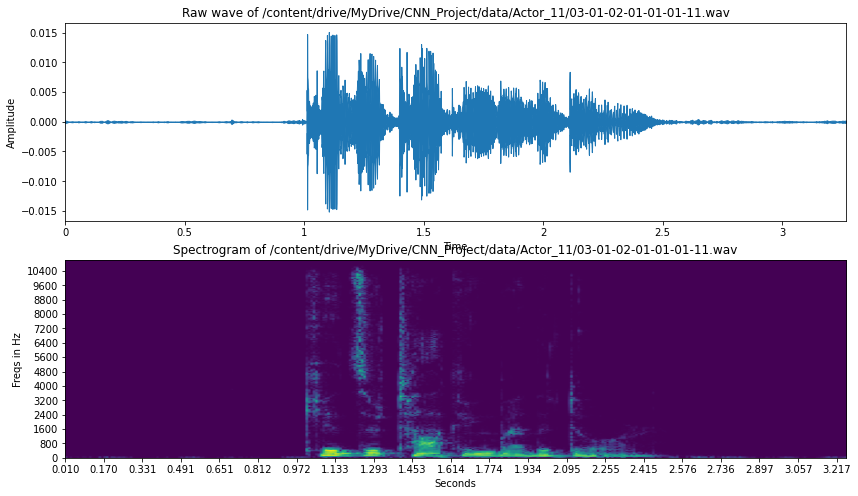

In [ ]:
# Plotting Wave Form and Spectrogram(
    #A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## Setting the labels

In [ ]:
label5_list = []
for i in range(len(datadf)):
    if datadf.emotion[i] == 2:
        lb = "_calm"
    elif datadf.emotion[i] == 3:
        lb = "_happy"
    elif datadf.emotion[i] == 4:
        lb = "_sad"
    elif datadf.emotion[i] == 5:
        lb = "_angry"
    elif datadf.emotion[i] == 6:
        lb = "_fearful"    
    
      
    
    # Add gender to the label  
    label5_list.append(datadf.gender[i] + lb)
    
len(label5_list)

1440

In [ ]:

datadf['label'] = label5_list
datadf.head()

,data,gender,emotion,label
0,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6,female_fearful
1,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,3,female_happy
2,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6,female_fearful
3,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,4,female_sad
4,/content/drive/MyDrive/CNN_Project/data/Actor_...,female,6,female_fearful


In [ ]:
print (datadf.label.value_counts().keys())

Index(['male_fearful', 'female_fearful', 'female_angry', 'male_angry',
       'male_calm', 'male_happy', 'female_happy', 'female_calm', 'male_sad',
       'female_sad'],
      dtype='object')


## Getting the features of audio files using librosa

In [ ]:
count = 0
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(datadf))):
    X, sample_rate = librosa.load(datadf.data[i], res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5) # path, 
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    featurelive = mfccs
    data.loc[count,'feature'] = featurelive
    count= count + 1

100%|██████████| 1440/1440 [09:51<00:00,  2.43it/s]


In [ ]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = datadf.label
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})
rnewdf = rnewdf.fillna(0)

# VII. Data Augmentation

In [ ]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




In [ ]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(datadf))):
    X, sample_rate = librosa.load(datadf.data[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if datadf.label[i]:

        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, datadf.label[i]]
        

100%|██████████| 1440/1440 [02:01<00:00, 11.81it/s]


In [ ]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(datadf))):
    X, sample_rate = librosa.load(datadf.data[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if datadf.label[i]:

        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, datadf.label[i]]
        

100%|██████████| 1440/1440 [06:29<00:00,  3.70it/s]


In [ ]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [ ]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
syndf1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-42.507470,-42.364639,-42.671333,-42.924347,-42.508409,-44.301522,-43.031224,-44.533240,-44.255230,-44.033588,-43.053125,-43.474855,-42.131538,-41.569299,-44.534477,-43.674271,-40.283266,-44.330684,-47.368422,-46.587867,-45.715513,-43.966189,-44.147278,-42.740814,-42.769531,-44.681088,-42.450689,-40.140015,-41.719584,-42.251687,-42.623476,-44.118195,-44.506522,-41.131176,-40.385368,-39.398868,-39.411207,-38.091966,-39.670286,-38.353570,...,-44.175778,-46.483096,-44.246106,-43.593764,-44.891337,-43.171289,-43.248770,-42.019051,-41.546761,-44.598623,-45.107926,-44.294697,-44.323920,-46.671340,-45.502486,-44.940329,-43.019077,-42.024073,-44.187039,-44.573754,-43.505871,-45.654883,-44.981400,-42.275584,-42.278371,-43.182366,-43.121619,-43.444642,-43.135268,-44.608709,-44.804208,-42.891868,-42.572511,-43.400228,-43.365296,-43.291571,-43.953057,-45.340102,-46.015441,female_fearful
1,-45.418731,-43.779038,-44.133848,-44.957165,-46.642139,-45.679637,-42.647180,-41.893230,-42.974166,-41.878182,-42.175114,-44.004686,-42.712299,-43.689270,-47.823129,-46.231565,-43.583189,-42.303415,-41.527313,-41.626264,-41.064397,-42.796520,-43.043828,-44.159943,-45.098770,-45.334795,-44.106682,-43.071919,-43.194403,-44.710292,-44.917138,-43.329278,-41.713409,-42.575297,-45.486237,-43.726240,-43.836798,-44.651011,-44.496013,-43.572718,...,-41.564577,-41.405174,-44.035094,-45.089941,-45.264119,-44.544636,-44.360179,-42.494337,-41.873910,-46.509486,-43.854451,-43.567817,-47.471172,-45.790826,-44.601995,-45.796310,-45.002162,-46.200248,-48.020047,-46.264776,-45.968771,-47.264975,-48.584278,-45.095224,-42.177867,-43.641751,-42.022689,-42.713331,-42.957193,-43.472581,-43.138203,-43.881062,-44.500499,-44.751564,-45.084972,-45.881528,-43.703964,-42.735298,-45.387624,female_happy
2,-32.143644,-31.097247,-31.094754,-31.459550,-32.667517,-32.445845,-32.848505,-31.633726,-31.171453,-32.596600,-31.649744,-32.004963,-33.446796,-36.594477,-34.423214,-31.800576,-33.105746,-32.999337,-31.457314,-32.397769,-33.203468,-32.642622,-31.978654,-32.297813,-30.099876,-29.524995,-29.544561,-30.030334,-29.628849,-31.848658,-30.762885,-29.286828,-31.090511,-31.446236,-29.686834,-30.649207,-32.401321,-31.328492,-32.127126,-34.505628,...,-33.395626,-31.705394,-32.491064,-31.830321,-35.059773,-33.679580,-33.571979,-32.766713,-33.275696,-34.614245,-34.012385,-33.166084,-32.758774,-32.210488,-31.812189,-32.171523,-32.649421,-32.622183,-32.538379,-35.737225,-35.871769,-35.686559,-34.528574,-35.735735,-35.665894,-33.666743,-30.368747,-31.813195,-31.181903,-32.565563,-33.908513,-32.813740,-31.271420,-32.263142,-30.881940,-31.269587,-32.974761,-35.570367,-37.393626,female_fearful
3,-53.101678,-49.629497,-48.124630,-47.663233,-47.414357,-46.895283,-47.750779,-49.002861,-49.450223,-51.208113,-48.284347,-49.532854,-49.768422,-47.118579,-46.844232,-47.565914,-46.732094,-46.019808,-47.142755,-46.101148,-46.438518,-46.758086,-48.400278,-48.160973,-49.187906,-50.424826,-51.267363,-48.096734,-46.656518,-48.529134,-46.200071,-45.758658,-47.957302,-48.450310,-49.173524,-49.438947,-48.327938,-48.991911,-47.988458,-49.472918,...,-44.790165,-44.891699,-46.635728,-44.727271,-45.664826,-46.342082,-44.606243,-44.713654,-45.921910,-44.346874,-44.742409,-47.466595,-47.818196,-47.097090,-48.473115,-50.911147,-50.721295,-49.997007,-50.513365,-48.819176,-47.814283,-48.668204,-48.789971,-48.899755,-48.312314,-50.400772,-50.750983,-51.736358,-52.769853,-49.684274,-49.718828,-51.669970,-50.656319,-49.196309,-49.574400,-50.836764,-49.191182,-47.824212,-46.565921,female_sad
4,-44.942207,-44.140903,-44.512343,-43.765212,-41.995565,-40.903134,-40.444966,-41.171828,-42.333729,-43.693813,-41.858960,-42.524919,-43.763453,-44.734922,-44.366299,-4

In [ ]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1440

In [ ]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,-51.902584,-52.353981,-52.741081,-51.768650,-52.477547,-51.622517,-51.330887,-51.659996,-50.603081,-51.142685,-52.419964,-53.580891,-52.117065,-49.855759,-51.856377,-51.861588,-49.699417,-50.430489,-53.587166,-54.631371,-55.023575,-53.884052,-50.963772,-50.207253,-46.496311,-44.754475,-45.884380,-46.161564,-48.224003,-46.932571,-47.695335,-50.185673,-50.812378,-49.203693,-48.655979,-49.528545,-48.023338,-46.376461,-48.063198,-46.254787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-50.805885,-50.081211,-48.507507,-48.846657,-49.324673,-50.057331,-49.539688,-47.899948,-48.293575,-48.275047,-48.114109,-47.884201,-46.191799,-47.404667,-50.699387,-49.815456,-48.994301,-48.453224,-46.289799,-46.027767,-46.130924,-49.049217,-49.610332,-50.652691,-50.221718,-49.737225,-49.282692,-48.856365,-48.419590,-52.309616,-51.932777,-51.075863,-48.891209,-48.640915,-50.010700,-49.765278,-50.868599,-51.361324,-50.467678,-50.509087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-42.496696,-40.683510,-39.928288,-40.250160,-40.637547,-40.223694,-40.783562,-40.889065,-40.087563,-40.934109,-42.025078,-42.960873,-43.393501,-42.719418,-42.893303,-42.123989,-41.408108,-40.893990,-39.966778,-39.943764,-39.504189,-40.439430,-39.968399,-39.762138,-38.579411,-38.406620,-38.297062,-36.970562,-36.273911,-36.906879,-35.395191,-34.440140,-34.393276,-34.011749,-33.986118,-34.980862,-38.378170,-38.113205,-40.132450,-39.760010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-59.254196,-55.769096,-53.499149,-53.206535,-51.857327,-51.743076,-53.126953,-53.163639,-53.088013,-54.972420,-52.746014,-52.072918,-52.828262,-51.359474,-50.730587,-50.929012,-50.067497,-48.487461,-49.765278,-49.355068,-48.961868,-49.730759,-49.795280,-50.999676,-53.039101,-56.675987,-57.383320,-53.619144,-51.364822,-52.131474,-49.508911,-49.515823,-50.912197,-49.816406,-51.001911,-51.632866,-51.382748,-52.125069,-52.022583,-53.765602,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-55.819839,-54.076801,-54.816719,-52.090027,-50.501907,-48.636063,-47.764511,-48.701775,-49.845596,-51.277885,-48.619076,-49.108051,-51.254612,-51.097012,-49.873081,-48.938431,-50.976357,-50.709797,-49.891685,-50.796230,-48.308289,-47.242718,-49.509907,-48.791790,-48.125034,-47.473160,-46.865250,-44.978031,-45.788601,-45.699150,-45.783573,-45.991062,-46.695496,-45.081276,-45.208595,-47.443607,-47.405704,-45.099998,-44.336716,-45.997963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

df3[:5]

In [ ]:


newdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,label
0,-51.902584,-52.353981,-52.741085,-51.768650,-52.477547,-51.622517,-51.330887,-51.659996,-50.603081,-51.142685,-52.419964,-53.580891,-52.117065,-49.855759,-51.856377,-51.861588,-49.699417,-50.430489,-53.587166,-54.631371,-55.023575,-53.884052,-50.963772,-50.207249,-46.496311,-44.754475,-45.884380,-46.161560,-48.224003,-46.932575,-47.695335,-50.185673,-50.812378,-49.203693,-48.655983,-49.528542,-48.023338,-46.376461,-48.063206,-46.254787,...,-25.778280,-29.300535,-31.860250,-33.540802,-33.845158,-37.254021,-37.995850,-38.110630,-41.999393,-42.264179,-41.996563,-44.192368,-46.438747,-48.432175,-46.078163,-43.903545,-42.903133,-43.608635,-44.554256,-45.194870,-43.807270,-45.325275,-44.903080,-45.917007,-47.138374,-47.504910,-47.793480,-47.954624,-44.243233,-45.562378,-46.703510,-45.953838,-47.489540,-48.091927,-48.895603,-49.874180,-49.468163,-46.761631,-46.996803,female_fearful
1,-50.805885,-50.081211,-48.507507,-48.846657,-49.324673,-50.057331,-49.539688,-47.899948,-48.293575,-48.275047,-48.114109,-47.884197,-46.191811,-47.404667,-50.699387,-49.815456,-48.994301,-48.453224,-46.289795,-46.027767,-46.130924,-49.049213,-49.610332,-50.652691,-50.221718,-49.737225,-49.282692,-48.856365,-48.419590,-52.309616,-51.932777,-51.075863,-48.891209,-48.640915,-50.010700,-49.765278,-50.868599,-51.361324,-50.467678,-50.509087,...,-28.381884,-28.693485,-28.287584,-30.212797,-30.316906,-29.318434,-29.538054,-29.998508,-30.554930,-30.167793,-31.691162,-34.494717,-34.891685,-35.741776,-33.519844,-34.151833,-35.603310,-37.763561,-38.342911,-40.384480,-42.914387,-42.110149,-44.055290,-45.634159,-47.066059,-45.615532,-44.619789,-44.241341,-43.889046,-45.090450,-43.127518,-44.854191,-47.850368,-44.638481,-44.379574,-46.842278,-47.953735,-47.058372,-45.793049,female_happy
2,-42.496696,-40.683510,-39.928288,-40.250160,-40.637547,-40.223694,-40.783562,-40.889065,-40.087563,-40.934109,-42.025078,-42.960873,-43.393501,-42.719418,-42.893303,-42.123989,-41.408108,-40.893990,-39.966778,-39.943764,-39.504189,-40.439430,-39.968399,-39.762138,-38.579411,-38.406616,-38.297062,-36.970558,-36.273911,-36.906879,-35.395191,-34.440140,-34.393276,-34.011753,-33.986118,-34.980862,-38.378170,-38.113205,-40.132450,-39.760010,...,-34.487198,-34.558670,-34.568417,-33.943707,-35.315102,-35.939976,-36.169785,-37.351437,-38.393284,-36.914406,-37.157478,-39.345055,-38.375587,-39.469116,-39.436565,-39.203285,-38.436512,-38.867649,-39.174046,-37.185699,-37.473892,-37.896172,-37.472145,-38.039024,-37.352638,-37.046383,-37.703281,-38.169373,-39.690872,-41.784466,-41.472263,-40.679695,-39.669472,-40.037289,-40.351265,-41.536926,-41.766762,-40.129128,-39.644192,female_fearful
3,-59.254196,-55.769096,-53.499149,-53.206535,-51.857327,-51.743076,-53.126953,-53.163639,-53.088013,-54.972420,-52.746014,-52.072918,-52.828262,-51.359474,-50.730587,-50.929012,-50.067497,-48.487461,-49.765278,-49.355068,-48.961868,-49.730759,-49.795280,-50.999676,-53.039101,-56.675987,-57.383320,-53.619144,-51.364822,-52.131474,-49.508911,-49.515823,-50.912197,-49.816406,-51.001911,-51.632866,-51.382748,-52.125069,-52.022583,-53.765602,...,-43.649010,-44.906754,-44.452969,-46.116142,-46.003071,-47.155441,-49.654964,-49.165489,-49.638386,-52.030205,-52.725056,-50.199600,-49.365704,-49.781490,-49.842957,-49.981697,-49.281448,-50.041824,-49.116856,-48.632725,-47.757149,-48.510857,-48.239361,-47.819405,-47.516251,-46.743546,-50.026306,-49.889347,-50.651325,-52.925991,-52.252792,-50.024021,-50.142239,-50.522766,-51.571918,-50.673416,-51.651291,-52.606575,-50.975716,female_sad
4,-55.819839,-54.076801,-54.816719,-52.090027,-50.501907,-48.636063,-47.764511,-48.701767,-49.845596,-51.277885,-48.619076,-49.108051,-51.254612,-51.097012,-49.873081,-4

In [ ]:


len(rnewdf)

1440

In [ ]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,label
0,-51.902584,-52.353981,-52.741085,-51.768650,-52.477547,-51.622517,-51.330887,-51.659996,-50.603081,-51.142685,-52.419964,-53.580891,-52.117065,-49.855759,-51.856377,-51.861588,-49.699417,-50.430489,-53.587166,-54.631371,-55.023575,-53.884052,-50.963772,-50.207249,-46.496311,-44.754475,-45.884380,-46.161560,-48.224003,-46.932575,-47.695335,-50.185673,-50.812378,-49.203693,-48.655983,-49.528542,-48.023338,-46.376461,-48.063206,-46.254787,...,-25.778280,-29.300535,-31.860250,-33.540802,-33.845158,-37.254021,-37.995850,-38.110630,-41.999393,-42.264179,-41.996563,-44.192368,-46.438747,-48.432175,-46.078163,-43.903545,-42.903133,-43.608635,-44.554256,-45.194870,-43.807270,-45.325275,-44.903080,-45.917007,-47.138374,-47.504910,-47.793480,-47.954624,-44.243233,-45.562378,-46.703510,-45.953838,-47.489540,-48.091927,-48.895603,-49.874180,-49.468163,-46.761631,-46.996803,female_fearful
1,-50.805885,-50.081211,-48.507507,-48.846657,-49.324673,-50.057331,-49.539688,-47.899948,-48.293575,-48.275047,-48.114109,-47.884197,-46.191811,-47.404667,-50.699387,-49.815456,-48.994301,-48.453224,-46.289795,-46.027767,-46.130924,-49.049213,-49.610332,-50.652691,-50.221718,-49.737225,-49.282692,-48.856365,-48.419590,-52.309616,-51.932777,-51.075863,-48.891209,-48.640915,-50.010700,-49.765278,-50.868599,-51.361324,-50.467678,-50.509087,...,-28.381884,-28.693485,-28.287584,-30.212797,-30.316906,-29.318434,-29.538054,-29.998508,-30.554930,-30.167793,-31.691162,-34.494717,-34.891685,-35.741776,-33.519844,-34.151833,-35.603310,-37.763561,-38.342911,-40.384480,-42.914387,-42.110149,-44.055290,-45.634159,-47.066059,-45.615532,-44.619789,-44.241341,-43.889046,-45.090450,-43.127518,-44.854191,-47.850368,-44.638481,-44.379574,-46.842278,-47.953735,-47.058372,-45.793049,female_happy
2,-42.496696,-40.683510,-39.928288,-40.250160,-40.637547,-40.223694,-40.783562,-40.889065,-40.087563,-40.934109,-42.025078,-42.960873,-43.393501,-42.719418,-42.893303,-42.123989,-41.408108,-40.893990,-39.966778,-39.943764,-39.504189,-40.439430,-39.968399,-39.762138,-38.579411,-38.406616,-38.297062,-36.970558,-36.273911,-36.906879,-35.395191,-34.440140,-34.393276,-34.011753,-33.986118,-34.980862,-38.378170,-38.113205,-40.132450,-39.760010,...,-34.487198,-34.558670,-34.568417,-33.943707,-35.315102,-35.939976,-36.169785,-37.351437,-38.393284,-36.914406,-37.157478,-39.345055,-38.375587,-39.469116,-39.436565,-39.203285,-38.436512,-38.867649,-39.174046,-37.185699,-37.473892,-37.896172,-37.472145,-38.039024,-37.352638,-37.046383,-37.703281,-38.169373,-39.690872,-41.784466,-41.472263,-40.679695,-39.669472,-40.037289,-40.351265,-41.536926,-41.766762,-40.129128,-39.644192,female_fearful
3,-59.254196,-55.769096,-53.499149,-53.206535,-51.857327,-51.743076,-53.126953,-53.163639,-53.088013,-54.972420,-52.746014,-52.072918,-52.828262,-51.359474,-50.730587,-50.929012,-50.067497,-48.487461,-49.765278,-49.355068,-48.961868,-49.730759,-49.795280,-50.999676,-53.039101,-56.675987,-57.383320,-53.619144,-51.364822,-52.131474,-49.508911,-49.515823,-50.912197,-49.816406,-51.001911,-51.632866,-51.382748,-52.125069,-52.022583,-53.765602,...,-43.649010,-44.906754,-44.452969,-46.116142,-46.003071,-47.155441,-49.654964,-49.165489,-49.638386,-52.030205,-52.725056,-50.199600,-49.365704,-49.781490,-49.842957,-49.981697,-49.281448,-50.041824,-49.116856,-48.632725,-47.757149,-48.510857,-48.239361,-47.819405,-47.516251,-46.743546,-50.026306,-49.889347,-50.651325,-52.925991,-52.252792,-50.024021,-50.142239,-50.522766,-51.571918,-50.673416,-51.651291,-52.606575,-50.975716,female_sad
4,-55.819839,-54.076801,-54.816719,-52.090027,-50.501907,-48.636063,-47.764511,-48.701767,-49.845596,-51.277885,-48.619076,-49.108051,-51.254612,-51.097012,-49.873081,-4

In [ ]:
rnewdf.isnull().sum().sum()

9

In [ ]:

rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,label
0,-51.902584,-52.353981,-52.741085,-51.768650,-52.477547,-51.622517,-51.330887,-51.659996,-50.603081,-51.142685,-52.419964,-53.580891,-52.117065,-49.855759,-51.856377,-51.861588,-49.699417,-50.430489,-53.587166,-54.631371,-55.023575,-53.884052,-50.963772,-50.207249,-46.496311,-44.754475,-45.884380,-46.161560,-48.224003,-46.932575,-47.695335,-50.185673,-50.812378,-49.203693,-48.655983,-49.528542,-48.023338,-46.376461,-48.063206,-46.254787,...,-25.778280,-29.300535,-31.860250,-33.540802,-33.845158,-37.254021,-37.995850,-38.110630,-41.999393,-42.264179,-41.996563,-44.192368,-46.438747,-48.432175,-46.078163,-43.903545,-42.903133,-43.608635,-44.554256,-45.194870,-43.807270,-45.325275,-44.903080,-45.917007,-47.138374,-47.504910,-47.793480,-47.954624,-44.243233,-45.562378,-46.703510,-45.953838,-47.489540,-48.091927,-48.895603,-49.874180,-49.468163,-46.761631,-46.996803,female_fearful
1,-50.805885,-50.081211,-48.507507,-48.846657,-49.324673,-50.057331,-49.539688,-47.899948,-48.293575,-48.275047,-48.114109,-47.884197,-46.191811,-47.404667,-50.699387,-49.815456,-48.994301,-48.453224,-46.289795,-46.027767,-46.130924,-49.049213,-49.610332,-50.652691,-50.221718,-49.737225,-49.282692,-48.856365,-48.419590,-52.309616,-51.932777,-51.075863,-48.891209,-48.640915,-50.010700,-49.765278,-50.868599,-51.361324,-50.467678,-50.509087,...,-28.381884,-28.693485,-28.287584,-30.212797,-30.316906,-29.318434,-29.538054,-29.998508,-30.554930,-30.167793,-31.691162,-34.494717,-34.891685,-35.741776,-33.519844,-34.151833,-35.603310,-37.763561,-38.342911,-40.384480,-42.914387,-42.110149,-44.055290,-45.634159,-47.066059,-45.615532,-44.619789,-44.241341,-43.889046,-45.090450,-43.127518,-44.854191,-47.850368,-44.638481,-44.379574,-46.842278,-47.953735,-47.058372,-45.793049,female_happy
2,-42.496696,-40.683510,-39.928288,-40.250160,-40.637547,-40.223694,-40.783562,-40.889065,-40.087563,-40.934109,-42.025078,-42.960873,-43.393501,-42.719418,-42.893303,-42.123989,-41.408108,-40.893990,-39.966778,-39.943764,-39.504189,-40.439430,-39.968399,-39.762138,-38.579411,-38.406616,-38.297062,-36.970558,-36.273911,-36.906879,-35.395191,-34.440140,-34.393276,-34.011753,-33.986118,-34.980862,-38.378170,-38.113205,-40.132450,-39.760010,...,-34.487198,-34.558670,-34.568417,-33.943707,-35.315102,-35.939976,-36.169785,-37.351437,-38.393284,-36.914406,-37.157478,-39.345055,-38.375587,-39.469116,-39.436565,-39.203285,-38.436512,-38.867649,-39.174046,-37.185699,-37.473892,-37.896172,-37.472145,-38.039024,-37.352638,-37.046383,-37.703281,-38.169373,-39.690872,-41.784466,-41.472263,-40.679695,-39.669472,-40.037289,-40.351265,-41.536926,-41.766762,-40.129128,-39.644192,female_fearful
3,-59.254196,-55.769096,-53.499149,-53.206535,-51.857327,-51.743076,-53.126953,-53.163639,-53.088013,-54.972420,-52.746014,-52.072918,-52.828262,-51.359474,-50.730587,-50.929012,-50.067497,-48.487461,-49.765278,-49.355068,-48.961868,-49.730759,-49.795280,-50.999676,-53.039101,-56.675987,-57.383320,-53.619144,-51.364822,-52.131474,-49.508911,-49.515823,-50.912197,-49.816406,-51.001911,-51.632866,-51.382748,-52.125069,-52.022583,-53.765602,...,-43.649010,-44.906754,-44.452969,-46.116142,-46.003071,-47.155441,-49.654964,-49.165489,-49.638386,-52.030205,-52.725056,-50.199600,-49.365704,-49.781490,-49.842957,-49.981697,-49.281448,-50.041824,-49.116856,-48.632725,-47.757149,-48.510857,-48.239361,-47.819405,-47.516251,-46.743546,-50.026306,-49.889347,-50.651325,-52.925991,-52.252792,-50.024021,-50.142239,-50.522766,-51.571918,-50.673416,-51.651291,-52.606575,-50.975716,female_sad
4,-55.819839,-54.076801,-54.816719,-52.090027,-50.501907,-48.636063,-47.764511,-48.701767,-49.845596,-51.277885,-48.619076,-49.108051,-51.254612,-51.097012,-49.873081,-4


## Dividing the data into test and train

In [ ]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit

X = rnewdf.drop(['label'], axis=1)
y = rnewdf.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
y_train.value_counts()

male_fearful      136
female_fearful    134
female_angry      127
male_angry        114
male_calm         112
male_happy        109
female_happy      106
female_calm       106
male_sad          105
female_sad        103
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

female_fearful    34
male_fearful      34
female_angry      31
male_angry        29
male_calm         28
female_happy      27
male_happy        27
male_sad          26
female_sad        26
female_calm       26
Name: label, dtype: int64

In [ ]:
X_train.isna().sum().sum()

0

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder


X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
X_train.shape

(3456, 259)

## Changing dimension for CNN model

In [ ]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [ ]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 259, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 259, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 259, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 259, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 259, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           8

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
216/216 [==============================] - 35s 9ms/step - loss: 2.3872 - accuracy: 0.1257 - val_loss: 2.2657 - val_accuracy: 0.1586
Epoch 2/700
216/216 [==============================] - 1s 6ms/step - loss: 2.2953 - accuracy: 0.1331 - val_loss: 2.2531 - val_accuracy: 0.1551
Epoch 3/700
216/216 [==============================] - 1s 6ms/step - loss: 2.2727 - accuracy: 0.1372 - val_loss: 2.2358 - val_accuracy: 0.1713
Epoch 4/700
216/216 [==============================] - 1s 6ms/step - loss: 2.2573 - accuracy: 0.1592 - val_loss: 2.2233 - val_accuracy: 0.1979
Epoch 5/700
216/216 [==============================] - 1s 6ms/step - loss: 2.2447 - accuracy: 0.1619 - val_loss: 2.2115 - val_accuracy: 0.1991
Epoch 6/700
216/216 [==============================] - 1s 6ms/step - loss: 2.2264 - accuracy: 0.1669 - val_loss: 2.2007 - val_accuracy: 0.1771
Epoch 7/700
216/216 [==============================] - 1s 6ms/step - loss: 2.2208 - accuracy: 0.1647 - val_loss: 2.1883 - val_accuracy: 0.213

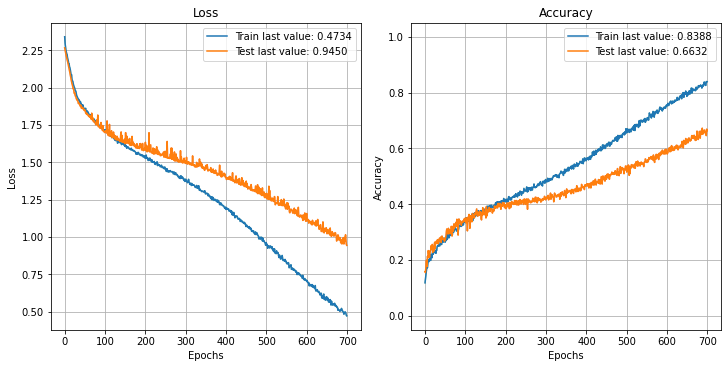

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt


plot_history(cnnhistory)
plt.show()

plt.close()


In [ ]:
score = model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 66.32%


## Saving the model

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join('/content/drive/MyDrive/CNN_Project/new model/', 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/CNN_Project/new model/saved_models/Emotion_Voice_Detection_Model.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/CNN_Project/new model/saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 66.32%


## Predicting emotions on the test data

In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

27/27 [==============================] - 0s 4ms/step


In [ ]:
preds

array([[2.5227882e-03, 4.5100049e-05, 4.4604119e-02, ..., 1.0423751e-02,
        8.7354642e-01, 3.3795368e-02],
       [2.8831246e-06, 2.1099703e-10, 3.9964100e-08, ..., 2.0168563e-03,
        1.6511038e-03, 2.8149352e-06],
       [1.3356192e-01, 5.7586338e-02, 7.6376195e-03, ..., 3.3296198e-01,
        3.1142958e-02, 2.8321874e-01],
       ...,
       [8.3146214e-01, 7.1605459e-02, 1.6291002e-02, ..., 1.6562853e-02,
        6.5902277e-04, 2.4861274e-03],
       [5.5744190e-06, 3.9461861e-07, 3.6433958e-06, ..., 1.0460019e-04,
        1.1150950e-03, 1.7325641e-04],
       [1.2782281e-02, 9.0098804e-01, 7.1037389e-02, ..., 1.5344829e-05,
        2.9432403e-03, 3.6895525e-04]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([8, 5, 7, 5, 8, 6, 9, 9, 9, 0, 9, 7, 3, 7, 5, 0, 1, 1, 0, 2, 8, 6,
       2, 7, 8, 0, 8, 8, 2, 3, 9, 8, 1, 6, 0, 7, 7, 2, 9, 8, 1, 1, 3, 4,
       6, 1, 3, 2, 7, 4, 3, 3, 1, 9, 7, 8, 1, 7, 4, 2, 8, 1, 6, 6, 8, 6,
       7, 3, 3, 8, 7, 1, 8, 4, 8, 8, 0, 4, 5, 9, 7, 4, 8, 3, 6, 6, 5, 5,
       5, 9, 1, 5, 9, 6, 3, 9, 9, 9, 6, 0, 0, 3, 4, 7, 3, 2, 2, 0, 6, 5,
       3, 7, 6, 3, 7, 1, 7, 6, 0, 8, 1, 3, 1, 8, 6, 2, 9, 8, 9, 7, 8, 4,
       7, 8, 7, 5, 7, 3, 7, 1, 7, 1, 9, 8, 6, 3, 1, 3, 7, 2, 4, 3, 9, 7,
       1, 2, 3, 8, 0, 1, 9, 5, 8, 1, 8, 9, 4, 3, 7, 3, 7, 2, 0, 0, 3, 8,
       3, 2, 5, 5, 3, 2, 6, 2, 8, 7, 3, 9, 2, 4, 3, 0, 8, 4, 7, 8, 3, 8,
       7, 6, 7, 5, 6, 9, 7, 1, 1, 9, 7, 1, 1, 0, 5, 1, 9, 2, 0, 2, 8, 3,
       8, 7, 1, 3, 8, 0, 0, 0, 2, 3, 7, 3, 7, 3, 0, 0, 6, 9, 9, 8, 0, 2,
       4, 3, 2, 7, 9, 6, 7, 2, 9, 1, 6, 6, 6, 5, 4, 3, 5, 1, 0, 0, 3, 8,
       2, 3, 1, 6, 0, 6, 7, 1, 1, 2, 4, 5, 2, 1, 4, 7, 5, 2, 3, 9, 3, 6,
       9, 0, 8, 8, 6, 9, 2, 6, 7, 6, 7, 3, 9, 4, 1,

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

preddf.head()

,predictedvalues
0,male_happy
1,male_angry
2,male_fearful
3,male_angry
4,male_happy


In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_happy
1,male_angry
2,female_angry
3,male_angry
4,male_happy
5,male_happy
6,male_happy
7,male_sad
8,male_fearful
9,male_happy


In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_fearful,male_fearful
171,female_fearful,female_fearful
172,male_happy,female_angry
173,female_angry,female_angry
174,female_angry,female_happy
175,male_angry,male_happy
176,female_happy,female_happy
177,female_fearful,female_fearful
178,male_angry,male_angry
179,male_angry,male_angry


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,95
female_calm,79
female_fearful,101
female_happy,80
female_sad,77
male_angry,86
male_calm,84
male_fearful,102
male_happy,81


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,94
female_calm,107
female_fearful,70
female_happy,100
female_sad,66
male_angry,72
male_calm,96
male_fearful,85
male_happy,89


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

66.31944444444444

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

66.07047865026512

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[68,  5,  4,  8,  2,  1,  0,  2,  4,  1],
       [ 1, 66,  0,  2,  7,  1,  0,  1,  0,  1],
       [12, 10, 55, 14,  6,  0,  0,  0,  2,  2],
       [ 3,  7,  3, 60,  7,  0,  0,  0,  0,  0],
       [ 3, 14,  4, 12, 41,  0,  0,  3,  0,  0],
       [ 2,  0,  1,  1,  0, 53, 12,  4,  8,  5],
       [ 0,  0,  0,  2,  1,  3, 65,  3,  7,  3],
       [ 2,  0,  3,  1,  0,  4, 11, 59,  9, 13],
       [ 3,  0,  0,  0,  1,  8,  5,  6, 52,  6],
       [ 0,  5,  0,  0,  1,  2,  3,  7,  7, 54]])

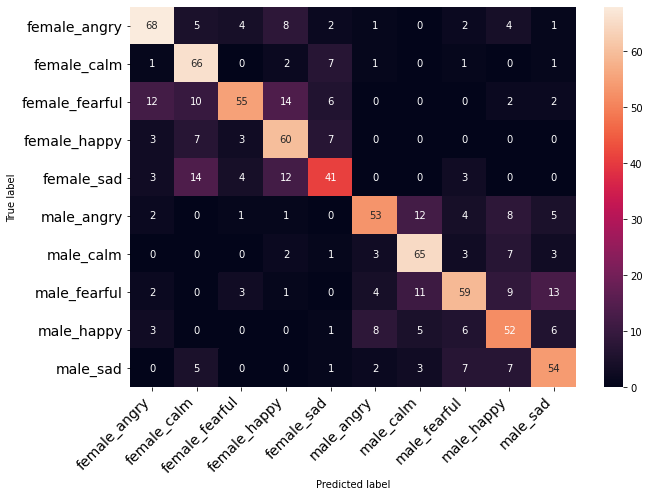

In [ ]:
# Visualize Confusion Matrix 

class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy','male_sad']


print_confusion_matrix(c, class_names)